# BERTでの多クラス分類（TF）


参考サイト

- Hugging Face: State-of-the-Art Natural Language Processing in ten lines of TensorFlow 2.0
    - https://blog.tensorflow.org/2019/11/hugging-face-state-of-art-natural.html
- HuggingFase公式
    - https://huggingface.co/transformers/training.html?highlight=keras
- (Part 1) tensorflow2でhuggingfaceのtransformersを使ってBERTを文書分類モデルに転移学習する
    - https://tksmml.hatenablog.com/entry/2019/10/22/215000
- (Part 2) tensorflow 2 でhugging faceのtransformers公式のBERT日本語学習済みモデルを文書分類モデルにfine-tuningする
    - https://tksmml.hatenablog.com/entry/2019/12/15/090900


In [23]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, RobertaTokenizer, TFBertModel, TFRobertaModel

import tensorflow as tf
from tensorflow.keras.models import Model

from tf_models import BertModel, RobertaModel
from utils import load_data, preprocess, build_vocabulary, seed_everything

In [8]:
# データのロード
dfs = load_data()

In [9]:
# 前処理
dfs['train']['clean_title'] = dfs['train'][['title']].apply(preprocess)
dfs['valid']['clean_title'] = dfs['valid'][['title']].apply(preprocess)
dfs['test']['clean_title'] = dfs['test'][['title']].apply(preprocess)

In [10]:
# 特徴量を取得
X_train = dfs['train']['clean_title']
X_valid = dfs['valid']['clean_title']
X_test = dfs['test']['clean_title']

In [11]:
# 目的変数の生成
category_dict = {'b': 0, 't': 1, 'e': 2, 'm': 3}
y_train = dfs['train']['category'].map(category_dict)
y_valid = dfs['valid']['category'].map(category_dict)
y_test = dfs['test']['category'].map(category_dict)

# BERTで学習

In [16]:
MODEL_NAME = 'bert-base-cased'
BATCH_SIZE = 24
AUTO = tf.data.experimental.AUTOTUNE
MAX_LEN = 250

In [15]:
# bert_model = TFBertModel.from_pretrained(MODEL_NAME)  # Automatically loads the config
bert_tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [17]:
def regular_encode(texts, tokenizer, maxlen):
    """This function tokenize the text according to a transformers model tokenizer
    """
    enc_di = tokenizer.batch_encode_plus(
        texts,
        padding='max_length',
        truncation=True,
        max_length=maxlen,
    )

    return np.array(enc_di['input_ids'])


def encode_texts(texts, tokenizer, maxlen=MAX_LEN):
    """This function encode our training sentences
    """
    texts = regular_encode(texts.tolist(), tokenizer, maxlen)
    return texts


def transform_to_tensors(x, y, is_train=True):
    """Function to transform arrays to tensors
    """
    if is_train:
        _dataset = (
            tf.data.Dataset
            .from_tensor_slices((x, y))
            .repeat()
            .shuffle(2048)
            .batch(BATCH_SIZE)
            .prefetch(AUTO)
        )
    else:
        _dataset = (
            tf.data.Dataset
            .from_tensor_slices((x, y))
            .batch(BATCH_SIZE)
            .prefetch(AUTO)
        )
    return _dataset

In [18]:
X_train

0        update   outkast goes back  1990s hip hop  coa...
1        china  stocks head  weekly gain  economic grow...
2        rare diamond shows earth  interior   wet  conf...
3        china credit gauge declines  officials seek  t...
4        angelina jolie  daniel day lewis   dame maggie...
                               ...                        
10667    fannie mae  pay treasury      billion  quarter...
10668    ultimate warrior killed   massive heart attack...
10669    miley cyrus forced  cancel   bangerz  tour dat...
10670    update   colorado reaps      mln  first month ...
10671    update   putin ally expects flurry  china deal...
Name: clean_title, Length: 10672, dtype: object

In [19]:
# encode
X_train = encode_texts(X_train, bert_tokenizer, MAX_LEN)
X_valid = encode_texts(X_valid, bert_tokenizer, MAX_LEN)
X_test = encode_texts(X_test, bert_tokenizer, MAX_LEN)

In [20]:
X_train

array([[  101, 11984,  1149, ...,     0,     0,     0],
       [  101,  5144,  1161, ...,     0,     0,     0],
       [  101,  4054,  9883, ...,     0,     0,     0],
       ...,
       [  101,  2837,  1183, ...,     0,     0,     0],
       [  101, 11984,  2942, ...,     0,     0,     0],
       [  101, 11984,  1508, ...,     0,     0,     0]])

In [21]:
train_dataset = transform_to_tensors(X_train, y_train, is_train=True)
valid_dataset = transform_to_tensors(X_valid, y_valid, is_train=False)
test_dataset = transform_to_tensors(X_test, y_test, is_train=False)

In [25]:
class BertModel:

    def __init__(self, model_name, max_len, output_dim=1):
        """モデルを構築する
        """
        self.transformer = TFBertModel.from_pretrained(model_name)
        self.input = tf.keras.layers.Input(shape=(max_len, ), dtype=tf.int32, name='input_word_ids')
        self.fc = tf.keras.layers.Dense(output_dim, activation='softmax', name='output')

    def build(self):
        input_layer = self.input
        sequence_output = self.transformer(input_layer)[0]
        cls_token = sequence_output[:, 0, :]  # We only need the cls_token, resulting in a 2d array
        output_layer = self.fc(cls_token)
        model = Model(inputs=[input_layer], outputs=[output_layer])
        return model

In [26]:
seed_everything(42)
tf.keras.backend.clear_session()
model = BertModel(model_name=MODEL_NAME, max_len=MAX_LEN, output_dim=len(y_train.unique())).build()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 250)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 108310272 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
output (Dense)               (None, 4)                 3076      
Total params: 108,313,348
Trainable params: 108,313,348
Non-trainable params: 0
_________________________________________________________________


In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[metric]
)

In [29]:
steps = X_train.shape[0] // (BATCH_SIZE * 16)
result = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    batch_size=BATCH_SIZE,
    epochs=3,
    steps_per_epoch=steps
)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"



27/27 [==============================] - 59s 1s/step - loss: 1.1933 - accuracy: 0.4861 - val_loss: 0.9039 - val_accuracy: 0.7234
Epoch 2/3
27/27 [==============================] - 33s 1s/step - loss: 0.6907 - accuracy: 0.7623 - val_loss: 0.5145 - val_accuracy: 0.8193
Epoch 3/3
27/27 [==============================] - 33s 1s/step - loss: 0.5179 - accuracy: 0.8148 - val_loss: 0.4615 - val_accuracy: 0.8291


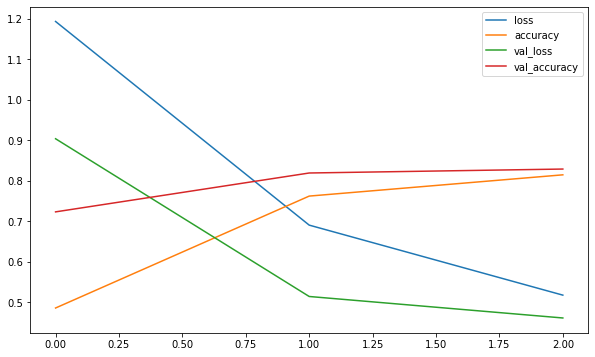

In [30]:
pd.DataFrame(result.history).plot(figsize=(10, 6))

In [31]:
# 推論
y_train_preds = model.predict(X_train, verbose=1)
y_valid_preds = model.predict(X_valid, verbose=1)
y_test_preds = model.predict(X_test, verbose=1)

42/42 [==============================] - 13s 308ms/step


In [32]:
y_train_preds

array([[2.0187939e-02, 2.7619533e-02, 9.3960875e-01, 1.2583814e-02],
       [9.9542195e-01, 3.9707078e-03, 2.6466904e-04, 3.4268916e-04],
       [2.8343579e-01, 5.7651573e-01, 7.5127400e-02, 6.4921126e-02],
       ...,
       [1.0202622e-02, 1.2631279e-02, 9.7265619e-01, 4.5099203e-03],
       [7.5909489e-01, 9.5179327e-02, 9.2228102e-03, 1.3650295e-01],
       [9.5987582e-01, 3.3854391e-02, 3.4627144e-03, 2.8071897e-03]],
      dtype=float32)

In [33]:
# 一番確率の高いクラスを取得
y_train_preds = np.argmax(y_train_preds, 1)
y_valid_preds = np.argmax(y_valid_preds, 1)
y_test_preds = np.argmax(y_test_preds, 1)

In [34]:
y_train_preds

array([2, 0, 1, ..., 2, 0, 0])

In [35]:
# 正解率を出力
print(f'Train Accuracy: {accuracy_score(y_train, y_train_preds)}')
print(f'Valid Accuracy: {accuracy_score(y_valid, y_valid_preds)}')
print(f'Test Accuracy: {accuracy_score(y_test, y_test_preds)}')

Train Accuracy: 0.8563530734632684
Valid Accuracy: 0.8290854572713643
Test Accuracy: 0.8403298350824587
